In [2]:
%%capture

%run ML_Record_Mining_JN.ipynb

In [1]:
# Loading libraries for modeling
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

import time

import os
path = r'/Users/seiryu8808/Desktop/UWinsc/Github/UnacquiredSites/src/output'

# Options
pd.options.mode.chained_assignment = None

NameError: name 'pd' is not defined

## Simple Modeling for Latitude and Longitude Coordinates

First, we need to encode the text data into vectors in order to apply a Classification algorithm.

In [5]:
data = nlp_bib_neotoma[['_gddid', 'sentid', 'words', 'words_as_string', 'dms_regex', 'dd_regex', 'latnorth', 'longeast', 'intersection_words_lat', 'intersection_words_long']]

In [6]:
data['words_as_string']

0         Available online at www.sciencedirect.com Quat...
1         The Chihuahueños Bog record extends to over 15...
2         An Artemisia steppe, then an open Picea woodla...
3         C/N ratios, δ13C and δ15N values indicate both...
4         Higher percentages of aquatic algae and elevat...
                                ...                        
106635                                                Ann .
106636                                        Sofia Univ. .
106637                                                Fac .
106638                                               Geol .
106639    Geogr85, 181198 (in Bulgarian with English sum...
Name: words_as_string, Length: 106640, dtype: object

In [7]:
data['has_both_lat_long_int'] = ((data['intersection_words_lat'].apply(len) != 0) & (data['intersection_words_long'].apply(len) != 0 ))

# Map True to One and False to Zero
data['has_both_lat_long_int'] = data['has_both_lat_long_int'].astype(int)

# Reduce data to columns of interest for this task.
data = data[['words_as_string', 'has_both_lat_long_int']]

# Define corpus for CountVectorizer
corpus = data['words_as_string'].tolist()

# Split data into training and testing sets
data_train, data_test = train_test_split(data, test_size = 0.20, random_state = 12)

# Translate words to vectors
# This model can add stopwords, punctuation, etc.
# For now, use all words.
vec = CountVectorizer(min_df=2, 
                      tokenizer=nltk.word_tokenize)

# Fit and transform training
X_train = vec.fit_transform(data_train['words_as_string']) 
y_train = data_train['has_both_lat_long_int']

# Transform test data without fitting
X_test = vec.transform(data_test['words_as_string']) 
y_test = data_test['has_both_lat_long_int']

Let's try to fit into different models to see which one renders the best performance. Take into consideration that this model will eventually be escalated to a bigger amount of data.

In [8]:
classifiers = {
#    'knn'           : KNeighborsClassifier(),
    'decision tree' : DecisionTreeClassifier(random_state = 0, max_depth = 15),
    'random forest' : RandomForestClassifier(n_estimators = 10)
#    'SVM'           : SVC(C = 100, gamma = "scale"),
#    'logistic reg'  : LogisticRegression(solver="lbfgs", max_iter = 10000)
}

In [9]:
def create_scores(classifiers = classifiers, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):
    train_scores = dict()
    test_scores = dict()
    training_times = dict()

    for classifier_name, classifier_obj in classifiers.items():
     #   print("Fitting", classifier_name)
        t = time.time()
        classifier_obj.fit(X_train, y_train)

        training_times[classifier_name] = time.time() - t
        train_scores[classifier_name] = classifier_obj.score(X_train, y_train)
        test_scores[classifier_name] = classifier_obj.score(X_test, y_test)

    data = {"train acc": train_scores, "valid acc" : test_scores, "training time (s)" : training_times}
    df = pd.DataFrame(data, columns = data.keys())
    df.index = list(classifiers.keys())
    return df

In [10]:
scores_df = create_scores()
scores_df

,train acc,valid acc,training time (s)
decision tree,0.999285,0.997984,0.702710
random forest,0.999660,0.997703,0.623006


We can see there is overfitting happening, since all testing scores are too good to be true.   
We also have to take into consideration that just 230 sentences have both coordinates out of over 100,000.   
With this data unbalance, guessing 0 over all sentences would still be a very high accuracy.

## Checking different scores such as confusion matrices

From the above matrix, we can see that SVM and Logistic Regression are computationally expensive. Taking into consideration that this experiment will eventually be scaled to a larger data set, let's discard these two methods. 

One way to know if a method is not missclassifying items, would be to check the confusion matrix and see how many false possitives or false negatives it has.

In [11]:
for classifier_name, classifier_obj in classifiers.items():
    print("Confusion Matrix", classifier_name)
    classifier_obj.fit(X_train, y_train)
    y_pred = classifier_obj.predict(X_test)
    conf_mat = confusion_matrix(y_test, y_pred).ravel()
    print(conf_mat)

Confusion Matrix decision tree
[21266    10    33    19]
Confusion Matrix random forest
[21276     0    47     5]


Although the random forest seems to have no false positives, it has 11 more false negatives. True positives are being completely missed. 
So, although it is faster to train, it is not a good model.

Let's then work with Decission Tree classifier and tune it to find the best parameters.

In [12]:
pd.options.display.float_format = '{:,.5f}'.format

In [13]:
min_samples_split_dict = {'sample_size':[], 'train_accuracy':[], 'test_accuracy' :[]}

for nsamples in range(2,200,20):
    model = DecisionTreeClassifier(min_samples_split = nsamples)
    model.fit(X_train, y_train)
    score = model.score(X_train,y_train)
    test_score = model.score(X_test,y_test)
    min_samples_split_dict['sample_size'].append(nsamples)    
    min_samples_split_dict['train_accuracy'].append(score)
    min_samples_split_dict['test_accuracy'].append(test_score)
    
min_samples_split_df = pd.DataFrame(min_samples_split_dict)
min_samples_split_df

,sample_size,train_accuracy,test_accuracy
0,2,1.00000,0.99803
1,22,0.99941,0.99794
2,42,0.99916,0.99789
3,62,0.99906,0.99794
4,82,0.99906,0.99812
5,102,0.99907,0.99794
6,122,0.99910,0.99812
7,142,0.99911,0.99789
8,162,0.99899,0.99803
9,182,0.99898,0.99798


In [14]:
max_depth_dict = {'max_depth':[], 'train_accuracy':[], 'test_accuracy':[]}

for nsamples in range(2,100,10):
    model = DecisionTreeClassifier(max_depth = nsamples)
    model.fit(X_train, y_train)
    score = model.score(X_train,y_train)
    test_sc = model.score(X_test, y_test)
    max_depth_dict['max_depth'].append(nsamples)    
    max_depth_dict['train_accuracy'].append(score)
    max_depth_dict['test_accuracy'].append(test_sc)
    
max_depth_df = pd.DataFrame(max_depth_dict)
max_depth_df

,max_depth,train_accuracy,test_accuracy
0,2,0.99807,0.99780
1,12,0.99916,0.99808
2,22,0.99939,0.99812
3,32,0.99951,0.99789
4,42,0.99972,0.99794
5,52,0.99988,0.99803
6,62,0.99998,0.99784
7,72,1.00000,0.99775
8,82,1.00000,0.99775
9,92,1.00000,0.99775


In [15]:
clf = DecisionTreeClassifier(min_samples_split = 40, max_depth = 12)

In [16]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=12,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=40,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Having chosen our hyperparameters, let's examine which features are the most important features.

In [17]:
# See which features are considered important
f_imp = clf.feature_importances_

feature_importance = 100.0 * (f_imp / f_imp.max())
feature_names = vec.get_feature_names()

In [18]:
# A holder for feature_name: feature_importance
feats = {} 
for feature, importance in zip(feature_names, feature_importance):
    feats[feature] = importance #add the name/value pair

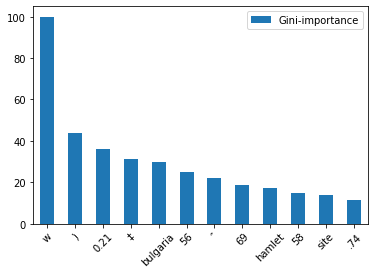

In [19]:
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance', ascending=False)[:12].plot(kind='bar', rot=45)

In [20]:
y_pred = clf.predict(X_test)

In [21]:
clf.score(X_test, y_test)

0.9979838709677419

In [22]:
confusion_matrix(y_test, y_pred).ravel()

array([21262,    14,    29,    23])

In [23]:
# Export csv to compare y_pred and y_test labels
guessed_label = pd.DataFrame(y_pred)
actual_label = pd.DataFrame(y_test)
actual_label = actual_label.reset_index()

# Join with sentences
original_sentence = pd.DataFrame(data_test['words_as_string'])
original_sentence = original_sentence .reset_index()

comparison_df = guessed_label.join(actual_label)
comparison_df = comparison_df.drop(columns=['index'])

comparison_df = comparison_df.join(original_sentence)
comparison_df = comparison_df.drop(columns=['index'])

In [24]:
output_file = os.path.join(path,'modeled_sentences.tsv')
comparison_df.to_csv(output_file, sep='\t', index = False)

One of the reasons for such a poor classification with the False Negatives, it is because data  is too unbalanced. 

We are going to address that problem now.

### Balancing DataSet

Although usually more data is better, we have a very few number of sentences that satisfy the condition of having "coordinates".

In order to balance training, I will only take 300 random sentences that have no coordinates. This will be even with sentences that have coordinates and maybe this will create less noise. 

In [25]:
data = nlp_bib_neotoma[['_gddid', 'sentid', 'words', 'words_as_string', 'dms_regex', 'dd_regex', 'latnorth', 'longeast', 'intersection_words_lat', 'intersection_words_long']]

In [26]:
data['has_both_lat_long_int'] = ((data['intersection_words_lat'].apply(len) != 0) & (data['intersection_words_long'].apply(len) != 0 ))

# Map True to One and False to Zero
data['has_both_lat_long_int'] = data['has_both_lat_long_int'].astype(int)

In [27]:
# Reduce data to columns of interest
data = data[['words_as_string', 'has_both_lat_long_int']]

In [28]:
from random import shuffle
data0 = data[data['has_both_lat_long_int'] == 0]
data0 = data0.sample(n = 300)
data1 = data[data['has_both_lat_long_int'] == 1]
data = pd.concat([data0, data1])
data.head(2)

,words_as_string,has_both_lat_long_int
51694,DOI : 10.111 / j.1365-2699 .2010.0238 .,0
83952,"On the other hand, laminated sediments (varves...",0


In [29]:
# Define corpus for CountVectorizer
corpus = data['words_as_string'].tolist()

# Split data into training and testing sets
data_train, data_test = train_test_split(data, test_size = 0.20, random_state = 12)

In [30]:
# Translate words to vectors
# This model can add stopwords, punctuation, etc.
# For now, use all words.
vec = CountVectorizer(min_df=2, 
                      tokenizer=nltk.word_tokenize)

# Fit and transform training
X_train = vec.fit_transform(data_train['words_as_string']) 
y_train = data_train['has_both_lat_long_int']

# Transform test data without fitting
X_test = vec.transform(data_test['words_as_string']) 
y_test = data_test['has_both_lat_long_int']

Using same model since we are just comparing 'Data Balancing'

In [31]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=12,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=40,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [32]:
clf.score(X_test, y_test)

0.8679245283018868

In [33]:
clf.score(X_train, y_train)

0.9457547169811321

In [45]:
clf.predict_proba(X_test)[:,1]

array([0.00473934, 0.37931034, 1.        , 1.        , 0.00473934,
       0.00473934, 0.37931034, 0.00473934, 0.00473934, 0.37931034,
       0.00473934, 0.00473934, 0.42857143, 0.00473934, 1.        ,
       1.        , 1.        , 1.        , 0.00473934, 0.37931034,
       1.        , 1.        , 1.        , 0.00473934, 0.94594595,
       0.00473934, 0.42857143, 0.37931034, 1.        , 1.        ,
       0.37931034, 1.        , 1.        , 0.00473934, 0.77272727,
       0.94594595, 0.00473934, 0.37931034, 1.        , 0.00473934,
       1.        , 0.00473934, 0.37931034, 0.00473934, 1.        ,
       0.94594595, 0.42857143, 1.        , 0.77272727, 0.94594595,
       0.77272727, 0.00473934, 0.77272727, 0.00473934, 0.77272727,
       1.        , 1.        , 0.77272727, 0.00473934, 1.        ,
       0.00473934, 1.        , 1.        , 0.00473934, 0.77272727,
       1.        , 0.00473934, 0.00473934, 0.77272727, 0.00473934,
       1.        , 0.94594595, 0.00473934, 0.00473934, 0.77272

In [47]:
import pickle

filename = 'finalized_model.sav'
pickle.dump(clf, open(filename, 'wb'))



In [52]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.8679245283018868


In [34]:
# See which features are considered important
f_imp = clf.feature_importances_
feature_importance = 100.0 * (f_imp / f_imp.max())
feature_names = vec.get_feature_names()

In [35]:
# A holder for feature_name: feature_importance
feats = {} 
for feature, importance in zip(feature_names, feature_importance):
    feats[feature] = importance #add the name/value pair

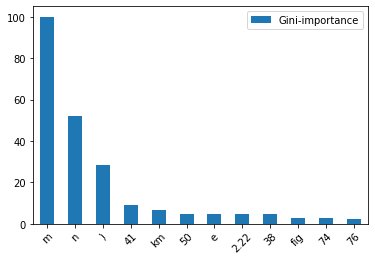

In [36]:
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance', ascending=False)[:12].plot(kind='bar', rot=45)

In [37]:
importances.sort_values(by='Gini-importance', ascending = False)[0:15]

,Gini-importance
m,100.00000
n,52.09199
),28.59326
41,8.94209
km,6.91247
...,...
74,2.61247
76,2.58794
polylepis,2.56988
communities,2.51849


In [38]:
y_pred = clf.predict(X_test)
confusion_matrix(y_test, y_pred).ravel()

array([50,  7,  7, 42])

We can see that we have improved significantly the percentage of True Positives and True Negatives.

In [39]:
Y_pred = clf.predict(X_test)
mse = sum((Y_pred - y_test)**2)
mse

14

In [40]:
guessed_label = pd.DataFrame(Y_pred)
actual_label = pd.DataFrame(y_test)
actual_label = actual_label.reset_index()

original_sentence = pd.DataFrame(data_test['words_as_string'])
original_sentence = original_sentence .reset_index()

comp_guessed_test_sm = guessed_label.join(actual_label)
comp_guessed_test_sm = comp_guessed_test_sm.drop(columns=['index'])

comp_guessed_test_sm = comp_guessed_test_sm.join(original_sentence)
comp_guessed_test_sm = comp_guessed_test_sm.drop(columns=['index'])
# comp_guessed_test_sm

In [41]:
import os
output_file = os.path.join(path,'small_model_sentences.tsv')
comp_guessed_test_sm.to_csv(output_file, sep='\t', index = False)

Conclusion for now:

Use a Tree Classifier with a max depth of 12.

Notes: What about Word2Vec or GloVe embeddings?

In [12]:
path = r'/Users/seiryu8808/Desktop'
data_file = r'preprocessed_sentences.tsv'

file = r'/Users/seiryu8808/Desktop/preprocessed_sentences.tsv'

In [13]:
df = pd.read_csv(file, sep='\t')

In [14]:
df

,_gddid,sentid,words,words_as_string,link_url
0,54b43266e138239d8684efed,1,"['Available', 'online', 'at', 'www.sciencedire...",Available online at www.sciencedirect.com Quat...,http://www.sciencedirect.com/science/article/p...
1,54b43266e138239d8684efed,2,"['The', 'Chihuahueños', 'Bog', 'record', 'exte...",The Chihuahueños Bog record extends to over 15...,http://www.sciencedirect.com/science/article/p...
2,54b43266e138239d8684efed,3,"['An', 'Artemisia', 'steppe', ',', 'then', 'an...","An Artemisia steppe, then an open Picea woodla...",http://www.sciencedirect.com/science/article/p...
3,54b43266e138239d8684efed,4,"['C/N', 'ratios', ',', 'δ13C', 'and', 'δ15N', ...","C/N ratios, δ13C and δ15N values indicate both...",http://www.sciencedirect.com/science/article/p...
4,54b43266e138239d8684efed,5,"['Higher', 'percentages', 'of', 'aquatic', 'al...",Higher percentages of aquatic algae and elevat...,http://www.sciencedirect.com/science/article/p...
...,...,...,...,...,...
111960,58d29193cf58f14928755ba5,80,"['Ann', '.']",Ann .,http://www.tandfonline.com/doi/abs/10.1080/001...
111961,58d29193cf58f14928755ba5,81,"['Sofia', 'Univ.', '.']",Sofia Univ. .,http://www.tandfonline.com/doi/abs/10.1080/001...
111962,58d29193cf58f14928755ba5,82,"['Fac', '.']",Fac .,http://www.tandfonline.com/doi/abs/10.1080/001...
111963,58d29193cf58f14928755ba5,83,"['Geol', '.']",Geol .,http://www.tandfonline.com/doi/abs/10.1080/001...
